# Дашборд для Яндекс.Дзен

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Экспорт-данных-в-csv-файл" data-toc-modified-id="Экспорт-данных-в-csv-файл-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Экспорт данных в csv-файл</a></span></li><li><span><a href="#Ссылка-на-дашборд-в-Tableau-Public" data-toc-modified-id="Ссылка-на-дашборд-в-Tableau-Public-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ссылка на дашборд в Tableau Public</a></span></li><li><span><a href="#Ссылка-на-презентацию-по-взаимодействию-пользователей-с-карточками-статей" data-toc-modified-id="Ссылка-на-презентацию-по-взаимодействию-пользователей-с-карточками-статей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Ссылка на презентацию по взаимодействию пользователей с карточками статей</a></span></li></ul></div>

**Описание проекта**

Мы анализируем пользовательские взаимодействия с карточками статей. Каждую карточку определяют её тема и источник (у него тоже есть тема). Примеры тем: "Красота и здоровье", "Россия", "Путешествия".

Пользователей системы характеризует возрастная категория. Скажем, "26-30" или "45+".

Есть три способа взаимодействия пользователей с системой:
- Карточка отображена для пользователя (`show`);
- Пользователь кликнул на карточку (`click`);
- Пользователь просмотрел статью карточки (`view`).

Каждую неделю менеджеры задают одни и те же вопросы:
- Cколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
- Как много событий генерируют источники с разными темами?
- Как соотносятся темы карточек и темы источников?

Необходимо автоматизировать этот процесс и сделать дашборд.

Дашборд будет основываться на пайплайне, который будет брать данные из таблицы, в которых хранятся сырые данные, трансформировать данные и укладывать их в агрегирующую таблицу. Пайплайн будет разработан дата-инженерами.

## Предобработка данных

Создадим коннекцию к базе, запишем в переменную `dash_data`:

In [1]:
# импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install psycopg2-binary

     ---------------------------------------- 1.2/1.2 MB 2.8 MB/s eta 0:00:00


In [3]:
db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string)

In [4]:
query = ''' SELECT *
            FROM dash_visits
        '''

dash_visits = pd.io.sql.read_sql(query, con = engine)

In [5]:
dash_visits

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27
...,...,...,...,...,...,...
30740,1071337,Юмор,Финансы,36-40,2019-09-24 18:57:00,2
30741,1071338,Юмор,Финансы,36-40,2019-09-24 19:00:00,1
30742,1071339,Юмор,Финансы,41-45,2019-09-24 18:54:00,1
30743,1071340,Юмор,Финансы,41-45,2019-09-24 18:56:00,1


Структура таблицы:
- `record_id` — первичный ключ,
- `item_topic` — тема карточки,
- `source_topic` — тема источника,
- `age_segment` — возрастной сегмент,
- `dt` — дата и время,
- `visits` — количество событий.

Проверим данные:

In [6]:
dash_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB


С данными все в порядке - пропусков нет, типы корректны.

Проверим дубликаты:

In [7]:
dash_visits.duplicated().sum()

0

Проверим каждый столбец с числовыми показателями:

In [8]:
print(dash_visits['record_id'].describe())
print(dash_visits['record_id'].nunique())

count    3.074500e+04
mean     1.055969e+06
std      8.875461e+03
min      1.040597e+06
25%      1.048283e+06
50%      1.055969e+06
75%      1.063655e+06
max      1.071341e+06
Name: record_id, dtype: float64
30745


С данными все в порядке - количество первичных ключей соответствует количеству строк в таблице.

In [9]:
print(dash_visits['visits'].describe())
print(dash_visits['visits'].nunique())

count    30745.000000
mean        10.089673
std         19.727601
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        371.000000
Name: visits, dtype: float64
212


Посмотрим покказатели на графике:

<Axes: >

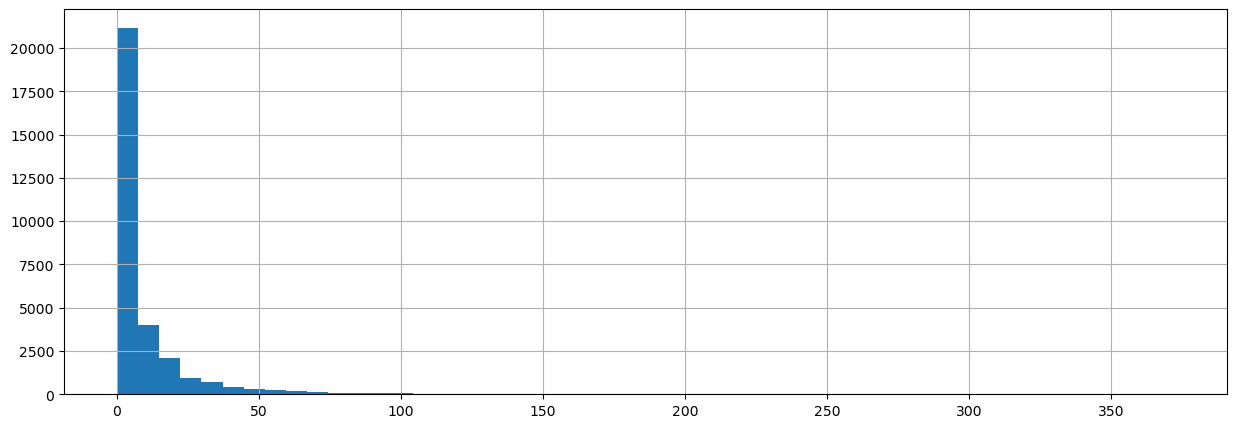

In [10]:
dash_visits['visits'].hist(bins=50, figsize=(15, 5), range=(0,372))

Большинство значений от 1 до 25. Есть выбросы, но мы оставим данные как есть.

Посмотрим на строковые столбцы:

In [11]:
for column in ['item_topic','source_topic','age_segment']:
    print(dash_visits[column].value_counts())
    print('Итого значений:', dash_visits[column].nunique())

Отношения             1536
Интересные факты      1535
Наука                 1505
Подборки              1456
Полезные советы       1424
Общество              1422
Россия                1385
История               1363
Семья                 1287
Путешествия           1247
Деньги                1234
Женщины               1230
Дети                  1229
Туризм                1206
Здоровье              1203
Красота               1193
Культура              1160
Юмор                  1129
Искусство             1119
Рассказы              1109
Психология            1056
Скандалы              1023
Знаменитости           976
Женская психология     914
Шоу                    804
Name: item_topic, dtype: int64
Итого значений: 25
Семейные отношения    1822
Россия                1687
Знаменитости          1650
Полезные советы       1578
Путешествия           1563
Кино                  1505
Дети                  1459
История               1437
Семья                 1405
Одежда                1379
Здоро

Столбец с датой:

In [12]:
print(dash_visits['dt'].describe())
print(dash_visits['dt'].sort_values().unique())
print('Итого значений:', dash_visits['dt'].nunique())

count                   30745
unique                     17
top       2019-09-24 18:58:00
freq                     3383
first     2019-09-24 18:28:00
last      2019-09-24 19:00:00
Name: dt, dtype: object
['2019-09-24T18:28:00.000000000' '2019-09-24T18:29:00.000000000'
 '2019-09-24T18:30:00.000000000' '2019-09-24T18:31:00.000000000'
 '2019-09-24T18:32:00.000000000' '2019-09-24T18:33:00.000000000'
 '2019-09-24T18:34:00.000000000' '2019-09-24T18:35:00.000000000'
 '2019-09-24T18:52:00.000000000' '2019-09-24T18:53:00.000000000'
 '2019-09-24T18:54:00.000000000' '2019-09-24T18:55:00.000000000'
 '2019-09-24T18:56:00.000000000' '2019-09-24T18:57:00.000000000'
 '2019-09-24T18:58:00.000000000' '2019-09-24T18:59:00.000000000'
 '2019-09-24T19:00:00.000000000']
Итого значений: 17


Получается, что в базе данные за один день - 24 сентября 2019 года.

**Вывод:**

Мы проверили данные - пропусков и дубликатов нет. Присутствуют выбросы в колонке с количеством событий, но мы оставим их как есть. Данные готовы для дальнейшего анализа.

## Экспорт данных в csv-файл

Для того чтобы в Tableau Public сформировать дашборд в соответствии с макетом, выгрузим файл `dash_visits` в формате `csv`.

In [13]:
dash_visits.to_csv('dash_visits.csv', index=False)

Протестируем, открывается ли он:

In [14]:
test = pd.read_csv('dash_visits.csv')
test

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27
...,...,...,...,...,...,...
30740,1071337,Юмор,Финансы,36-40,2019-09-24 18:57:00,2
30741,1071338,Юмор,Финансы,36-40,2019-09-24 19:00:00,1
30742,1071339,Юмор,Финансы,41-45,2019-09-24 18:54:00,1
30743,1071340,Юмор,Финансы,41-45,2019-09-24 18:56:00,1


**Вывод:**

Данные экспортированы в файл `dash_visits.csv`.

## Ссылка на дашборд в Tableau Public

https://public.tableau.com/app/profile/julia3332/viz/Project_JuliaTa/Dashboard1

## Ссылка на презентацию по взаимодействию пользователей с карточками статей

https://disk.yandex.ru/i/AXwXQtbTgIL1MA